# Plot average peri-event per-channel power

In [1]:
import numpy as np
import pandas as pd
import physutils
import dbio
import os
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

## Set up parameters:

In [2]:
# which patient, dataset to plot
dtup = 18, 1

Choose which event to align to:

In [3]:
which_align = 'stops'
# which_align = 'starts'

In [4]:
# set up relevant params
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']  # which bands to limit to

if which_align == 'stops':
    Tpre = -5  # time before event to grab
    Tpre_plot = -2.5  # time before event to plot
    Tpost = 1.5  # time after event to grab
elif which_align == 'starts':
    Tpre = -2
    Tpre_plot = -1
    Tpost = 2.5
    
smwid = 0.2  # smoothing window (in s)

## Load and preprocess data

In [5]:
# load data
os.chdir(os.path.expanduser('~/code/hephys/bartc'))
dbname = os.path.expanduser('~/data/bartc/plexdata/bartc.hdf5')
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

In [6]:
# bandpass filter
lfp = lfp.bandlimit(bands)

In [7]:
# decimate to 40 Hz
lfp = lfp.decimate(5)

In [8]:
# instantaneous power
lfp = lfp.instpwr()

In [9]:
# censor
lfp = lfp.censor()

In [10]:
# get events
evt = dbio.fetch(dbname, 'events', *dtup)
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']

if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops
    
if which_align == 'stops':
    ev_times = stops_free
    trial_types = evt['trial_type'][stops_free.index]
elif which_align == 'starts':
    ev_times = starts
    trial_types = evt['trial_type']

## Group data: median across times, mean across channels (within band)

In [11]:
# make peri-stop frame
# normalize each (band, channel) separately
evt_split = physutils.LFPset(lfp.evtsplit(ev_times, Tpre, Tpost)).rzscore()

In [12]:
# groupby accepts an iterable of functions to group by
# each function gets an index tuple (note: first element of tuple is trial index (not trial number!))
group_by_trial_type = lambda x: trial_types.iloc[x[0]]  # get trial type by index
group_by_trial = lambda x: trial_types.index[x[0]]
group_by_time = lambda x: x[1]  # get trial time
group_by_band = lambda x: x.split('.')[0]  # extract band from <band>.<number>
grpfuns = group_by_trial_type, group_by_time
grouped = evt_split.groupby(grpfuns)

# now get median across all trials for each (type, time, channel)
med_by_type = grouped.median()
med_across_chans = med_by_type.groupby(group_by_band, axis=1).mean()

# make trial type a column
meds = med_across_chans.unstack(level=0)
meds.index.name = 'time'

In [13]:
# make peri-stop frame
pow_df = physutils.LFPset(meds, meta=lfp.meta.copy())
pow_df = pow_df.smooth(smwid)

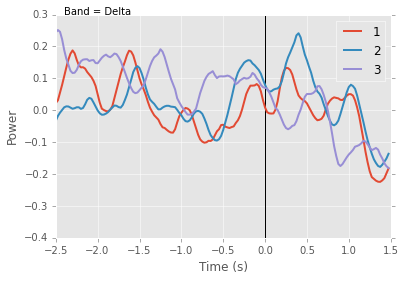

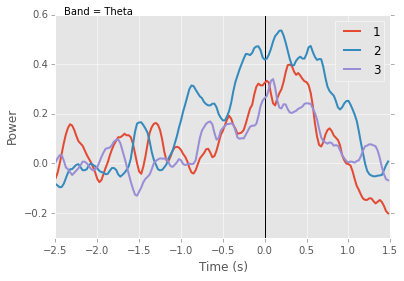

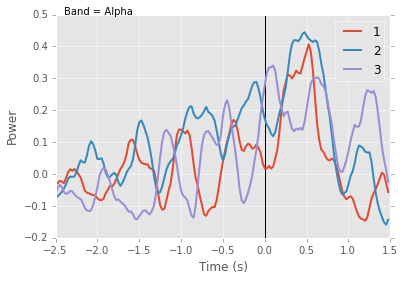

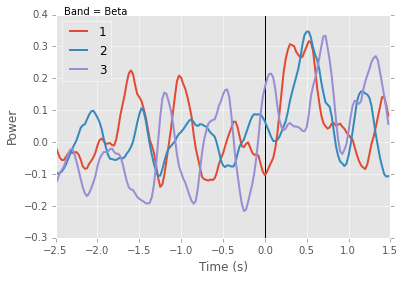

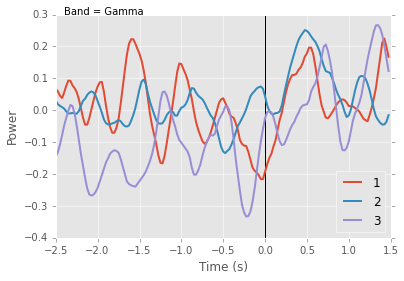

In [14]:
voffset = -0.001

for bb in bands:
        this_df = pow_df.loc[:, bb]
        this_df.plot(linewidth=2.0)
        plt.xlim([Tpre_plot, Tpost])
        
        # decorations
        plt.axvline(x=0, color='k', zorder=1)
        #plt.text(0.05, plt.ylim()[0] + 0.25, 'Stop', fontweight='bold')
        plt.tick_params(axis='x', which='both', top='off');
        #plt.text(plt.xlim()[1] - 1, plt.ylim()[1] + voffset, "Dataset {}".format(str(dtup)))
        plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1], "Band = {}".format(bb.capitalize()))
        
        plt.ylabel('Power')
        plt.xlabel('Time (s)')

## Compare mean power across trials:

In [15]:
if which_align == 'stops':
    interval = (-2, 0)
elif which_align == 'starts':
    interval = (0, 2)

In [16]:
# select smaller interval to average over
# get (all types, times in interval), all columns
interval_split = evt_split.loc[(slice(None), slice(*interval)), :]

In [17]:
# mean across time within trial
mn_trial_pwr = interval_split.groupby([group_by_trial_type, group_by_trial]).mean() 
mn_band_pwr = mn_trial_pwr.groupby(group_by_band, axis=1).mean()
mn_band_pwr.index.names = 'Type', 'Trial'
df_trials = mn_band_pwr.reset_index(level=0)
df_log = np.log(mn_band_pwr).reset_index(level=0)

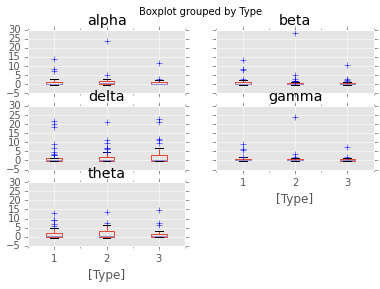

In [18]:
df_trials.boxplot(by='Type');

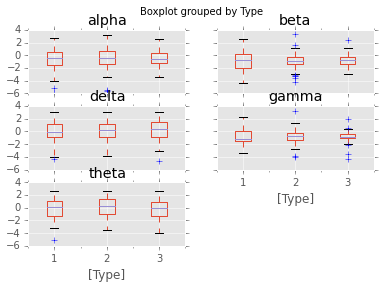

In [19]:
df_log.boxplot(by='Type');

In [20]:
import seaborn as sns

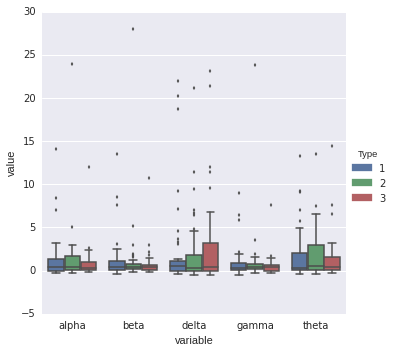

In [21]:
dfm = pd.melt(df_trials, id_vars='Type')
sns.factorplot('variable', 'value', hue='Type', data=dfm, kind='box');

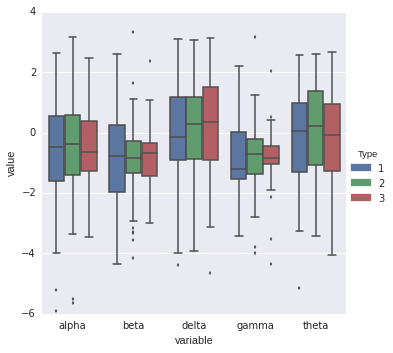

In [22]:
dfm = pd.melt(df_log, id_vars='Type')
sns.factorplot('variable', 'value', hue='Type', data=dfm, kind='box');